# Derive bolometric luminosity from a full SED

Assemble a hybrid full SED by combining observed spectra with a model spectrum, and then derive the bolometric luminosity.

In [1]:
from astropy.io import fits, ascii
import seda
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, NullFormatter
import importlib


    SEDA v0.1.3 package imported


Read the observed spectra of interest.

As an example here, let's read the near-infrared IRTF/SpeX, the mid-infrared JWST/NIRSpec, and the mid-infrared Spitzer/IRS spectra for the T8 (~750 K) brown dwarf 2MASS J04151954-0935066 in [Burgasser et al. (2004)](https://ui.adsabs.harvard.edu/abs/2004AJ....127.2856B/abstract), [Alejandro Merchan et al. (2025)](https://ui.adsabs.harvard.edu) and [Suárez & Metchev (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract), respectively.

Read SpeX spectrum:

In [2]:
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read JWST NIRSpec spectrum

In [3]:
NIRSpec_name = 'data/0415-0935_NIRSpec_spectrum.dat'
NIRSpec = ascii.read(NIRSpec_name)
wl_NIRSpec = NIRSpec['wl(um)'] # um 
flux_NIRSpec = NIRSpec['flux(Jy)'] # Jy
eflux_NIRSpec = NIRSpec['eflux(Jy)'] # Jy

# convert NIRSpec fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.convert_flux(wl=wl_NIRSpec, flux=flux_NIRSpec, eflux=eflux_NIRSpec, 
                                     unit_in='Jy', unit_out='erg/s/cm2/A')
flux_NIRSpec = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_NIRSpec = out_convert_flux['eflux_out'] # in erg/s/cm2/A

# remove a few negative fluxes and edge points
mask = (flux_NIRSpec>0) & ((wl_NIRSpec<3.68) | (wl_NIRSpec>3.79))
wl_NIRSpec = wl_NIRSpec[mask]
flux_NIRSpec = flux_NIRSpec[mask]
eflux_NIRSpec = eflux_NIRSpec[mask]

Read IRS spectrum:

In [4]:
IRS = ascii.read('data/0415-0935_IRS_spectrum.dat')
wl_IRS = IRS['wl(um)'] # in um
flux_IRS = IRS['flux(Jy)'] # in Jy
eflux_IRS = IRS['eflux(Jy)'] # in Jy

# convert IRS fluxes from Jy to erg/s/cm2/A
out_convert_flux = seda.convert_flux(wl=wl_IRS, flux=flux_IRS, eflux=eflux_IRS, 
                                     unit_in='Jy', unit_out='erg/s/cm2/A')
flux_IRS = out_convert_flux['flux_out'] # in erg/s/cm2/A
eflux_IRS = out_convert_flux['eflux_out'] # in erg/s/cm2/A

Plot SED to check everything looks okay:

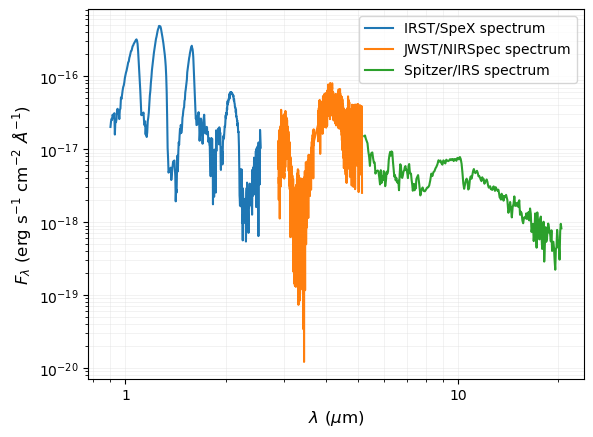

In [5]:
fig, ax = plt.subplots()

plt.plot(wl_SpeX, flux_SpeX, label='IRST/SpeX spectrum')
plt.plot(wl_NIRSpec, flux_NIRSpec, label='JWST/NIRSpec spectrum')
plt.plot(wl_IRS, flux_IRS, label='Spitzer/IRS spectrum')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)
ax.legend()

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

Read model to complement observed SED:

In [6]:
# select the atmospheric models of interest
model = 'ATMO2020'

# path to the directory or directories containing the model spectra
# (update it to your own path)
my_path = '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/ATMO2020/atmosphere_models/'
model_dir = [my_path+'CEQ_spectra/',
             my_path+'NEQ_weak_spectra/',
             my_path+'NEQ_strong_spectra/',
            ]
# parameters to generate the model spectrum
params = {'Teff': 757, 'logg': 4.33, 'logKzz': 3.53}

# generate the desired model spectrum
out = seda.generate_model_spectrum(model=model, params=params, model_dir=model_dir, save_spectrum=True)
wl_model = out['wavelength'] # micron
flux_model = out['flux'] # erg/s/cm2/A


      8 model spectra selected with:
         Teff range = [700. 800.]
         logg range = [4.  4.5]
         logKzz range = [0. 4.]


Reading model grid:   0%|          | 0/8 [00:00<?, ?it/s]

      elapsed time: 0.0 s


Show model:

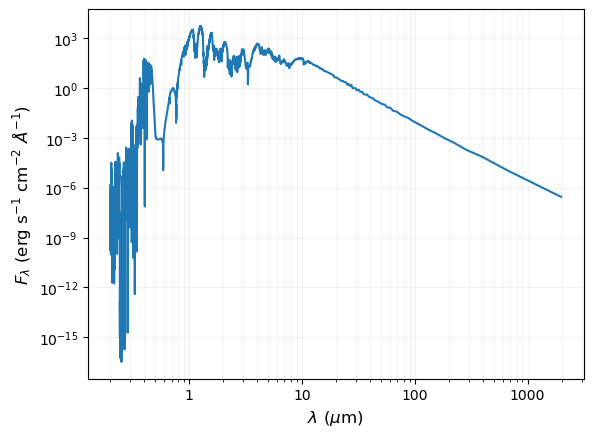

In [7]:
fig, ax = plt.subplots()

plt.plot(wl_model, flux_model)

plt.xscale('log')
plt.yscale('log')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

ax.grid(True, which='both', color='gainsboro', linewidth=0.5, alpha=0.5)

plt.xlabel(r'$\lambda\ (\mu$m)', size=12)
plt.ylabel(r'$F_\lambda\ ($erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', size=12)

plt.show()

Derive the bolometric luminosity by constructing a full hybrid SED using observations and models

In [28]:
importlib.reload(seda.phy_params)
importlib.reload(seda)

# wavelenghts
wl_spectra = [wl_SpeX, wl_NIRSpec, wl_IRS] # in um
# fluxes
flux_spectra = [flux_SpeX, flux_NIRSpec, flux_IRS] # in erg/s/cm2/A
# flux uncertainties
eflux_spectra = [eflux_SpeX, eflux_NIRSpec, eflux_IRS] # in erg/s/cm2/A
# specify flux units
flux_unit = 'erg/s/cm2/A'
# resolution of each input spectrum (used to convolve the model spectra)
res = [100, 2700, 100] # SpeX, NIRSpec, IRS

# distance to the target (optional and used to derive a radius)
distance = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
edistance = 0.06 # pc

out_bol_lum = seda.bol_lum(wl_spectra=wl_spectra, flux_spectra=flux_spectra, eflux_spectra=eflux_spectra, 
                           flux_unit=flux_unit, distance=distance, edistance=edistance, 
                           wl_model=wl_model, flux_model=flux_model, res=res)


   Input data loaded successfully
      3 input spectra

   Model options loaded successfully
            the spectrum will be convolved but will be essentially the same.

   Chi-square fit options loaded successfully
      elapsed time: 0.0 s

   Running chi-square fitting...


Minimizing chi-square:   0%|          | 0/1 [00:00<?, ?it/s]


   Chi-square fit ran successfully
      elapsed time: 0.0 s
   Gap detected between input spectra #0 and #1

log(Lbol) = -5.670\pm0.019

The observed SED is 96.9% complete

Contribution to the total observed SED (in flux or luminosity)
   spectrum #0: 51.6%
   spectrum #1: 25.0%
   spectrum #2: 23.4%
Contribution to the total hybrid full SED (in flux or luminosity)
   spectrum #0: 50.0%
   spectrum #1: 24.2%
   spectrum #2: 22.7%


Plot hybrid SED used to derived Lbol:

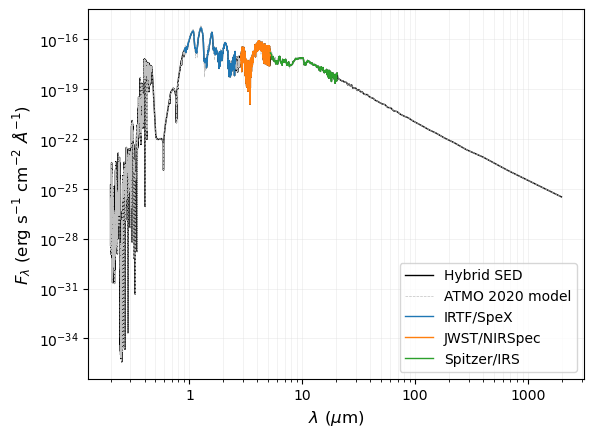

In [29]:
# set labels for input spectra and model spectrum
spectra_label = ['IRTF/SpeX', 'JWST/NIRSpec', 'Spitzer/IRS']
model_label = 'ATMO 2020 model'

seda.plot_full_SED(out_bol_lum, spectra_label=spectra_label, model_label=model_label)